In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df_logs = pd.read_csv('tmp/logs.csv', parse_dates=['timestamp'])
df_logs.head()

,timestamp,tasks,batch_id,processed_%,seconds,task_type,run_id
0,2025-06-08 16:19:23.643000+00:00,1-1-4,1,3.23,1.967,loaders,9290d4f5-5dad-4e54-b870-69ef3bff7d12
1,2025-06-08 16:19:26.169000+00:00,1-1-4,2,6.45,2.494,loaders,9290d4f5-5dad-4e54-b870-69ef3bff7d12
2,2025-06-08 16:19:28.635000+00:00,1-1-4,3,9.68,2.429,loaders,9290d4f5-5dad-4e54-b870-69ef3bff7d12
3,2025-06-08 16:19:30.853000+00:00,1-1-4,4,12.90,2.192,loaders,9290d4f5-5dad-4e54-b870-69ef3bff7d12
4,2025-06-08 16:19:33.019000+00:00,1-1-4,5,16.13,2.133,loaders,9290d4f5-5dad-4e54-b870-69ef3bff7d12


In [ ]:
cols = ['extractors', 'transformers', 'loaders']
df_time_span = (
    df_logs
    .groupby(['run_id', 'task_type'])['timestamp']
    .agg(start_time='min', end_time='max')
    .reset_index()
)
df_time_span['start_time'] = pd.to_datetime(
    df_time_span['start_time'], errors='coerce')
df_time_span['end_time'] = pd.to_datetime(
    df_time_span['end_time'], errors='coerce')
df_time_span['duration'] = (
    df_time_span['end_time'] - df_time_span['start_time']
).dt.total_seconds()
df_grouped = (
    df_time_span
    .pivot(index='run_id', columns='task_type', values='duration')
    .fillna(0)
    .reset_index()
)
df_grouped['total_pipeline_time'] = df_grouped[cols].max(axis=1)
config_map = df_logs[['run_id', 'tasks']].drop_duplicates()
df_summary = df_grouped.merge(config_map, on='run_id')
result = \
    df_summary.copy()[['run_id'] + cols + ['total_pipeline_time', 'tasks']]
result['etl_variance'] = result[cols].var(axis=1)
result = result.sort_values(by='etl_variance').head(20)
result

,run_id,extractors,transformers,loaders,total_pipeline_time,tasks,etl_variance
22,2354d464-ef8d-437f-89ff-3014b6fd8bf2,87.129,92.396,90.037,92.396,3-5-4,6.960439
56,72d90dd1-eaab-4415-990e-40269e13c5c6,264.287,250.912,266.522,266.522,1-2-1,71.259658
13,12537a8c-b247-4a77-891e-66fda4ae1d65,131.409,115.094,129.901,131.409,2-4-2,81.283423
29,3394d093-a8b3-4071-bec8-ab0c70dddc95,87.520,92.612,105.180,105.180,3-5-3,82.626448
2,0250dedc-a09b-49b1-987b-cf3fbae2a833,85.423,91.932,68.811,91.932,3-5-5,142.151044
72,9f2c51d4-12aa-4b6e-b84e-7a75115ae7c0,128.226,152.545,138.817,152.545,2-3-2,148.673504
34,3c73181a-1f8c-4bca-8a54-cd5d7713d5ad,65.755,93.322,76.353,93.322,4-5-4,193.367342
111,e2ba87c3-b0be-4b0c-8c64-939ef97aed55,88.714,118.400,97.053,118.400,3-4-3,234.415321
119,f35e78ce-bc7f-47e0-81b4-e8b53354b70d,66.850,95.710,92.864,95.710,4-5-3,252.954585
77,a62faef2-93e4-49a3-b682-7d28db45895d,83.408,116.992,92.744,116.992,3-4-4,300.501909


In [17]:
df_summary[df_summary['tasks'] == '1-1-1']
sequential_time = sum([df_summary[c].values[0] for c in cols])
result['sequential_time'] = sequential_time
print(sequential_time, 'seconds')

347.926 seconds


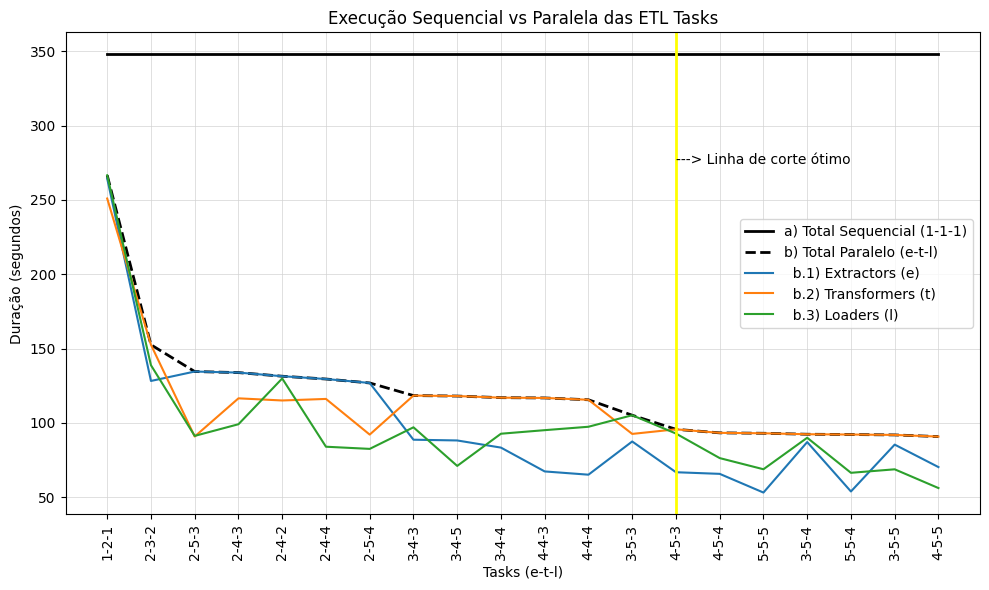

In [69]:
result_sorted = result.sort_values(by='total_pipeline_time', ascending=False)

plt.figure(figsize=(10, 6))
plt.plot(result_sorted['tasks'], result_sorted['sequential_time'], 
         label='a) Total Sequencial (1-1-1)', color='black', linewidth=2)
plt.plot(result_sorted['tasks'], result_sorted['total_pipeline_time'], 
         label='b) Total Paralelo (e-t-l)', 
         color='black', linestyle='--', linewidth=2)
plt.plot(result_sorted['tasks'], 
         result_sorted['extractors'], 
         label='  b.1) Extractors (e)')
plt.plot(result_sorted['tasks'], 
         result_sorted['transformers'], 
         label='  b.2) Transformers (t)')
plt.plot(result_sorted['tasks'], 
         result_sorted['loaders'], 
         label='  b.3) Loaders (l)')
plt.xlabel('Tasks (e-t-l)')
plt.ylabel('Duração (segundos)')
plt.title('Execução Sequencial vs Paralela das ETL Tasks')
plt.xticks(rotation=90)
plt.axvline(x=13, color='yellow', linewidth=2)
ymax = plt.ylim()[1]
plt.text(13, ymax * 0.75, '---> Linha de corte ótimo', color='black', 
         va='bottom', ha='left', fontsize=10)
plt.legend()
plt.tight_layout()
plt.grid(color='lightgray', linewidth=0.5)
plt.show()